In [1]:
# boas práticas: criar uma célula com todas as bibliotecas necessárias
# importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Turmas 2017.2
# http://dados.ufrn.br/dataset/turmas

# turmas
turmas_url = 'http://bit.do/turmas_ufrn_2017_2'

# matrículas em componentes em 2017.2
notas_url = 'http://bit.do/notas_ufrn_2017_2'

# componentes curriculares presenciais
disciplinas_url = 'http://bit.do/componentes_curriculares_ufrn'

# docentes da ufrn atualizado em 2018
docentes_url = 'http://bit.do/docentes_ufrn_2018'

# turmas 2017.2
turmas = pd.read_csv(turmas_url, sep=';')

# matriculas em componentes em 2017.2
notas = pd.read_csv(notas_url, sep=';')

# componentes curriculares presenciais
# por alguma razão ou outra, esse dataset tinha algum lixo em linhas que ocasionava 
# erros de leitura, dessa forma foi realizado um filtro apenas por colunas mais importantes
disciplinas = pd.read_csv(disciplinas_url, 
                          sep=';', 
                          usecols=["id_componente","codigo","nivel","nome","unidade_responsavel"])

docentes = pd.read_csv(docentes_url, sep=';')

In [3]:
# Adaptando o dataframe turma e disciplinas para o merge
# Esse procedimento é necessário pois o dataframe turma está codificado com ids

# A coluna id_componente precisa ser a mesma em ambos os dataframes
turmas.rename(columns={'id_componente_curricular': 'id_componente'}, inplace=True)

# id_componente em ambos os dataframes precisam ser do mesmo tipo
turmas.id_componente = turmas.id_componente.astype(str)

# Limpando o dataframe disciplinas com linhas desnecessárias
disciplinas.dropna(inplace=True)
disciplinas = disciplinas[~disciplinas.id_componente.duplicated()]

In [4]:
# Fazendo um merge entre o dataframe turmas e disciplinas utilizando como base a coluna id_componente
# https://pandas.pydata.org/pandas-docs/stable/merging.html
colunas = ["id_turma","id_docente_interno","codigo","nivel_ensino","nome","unidade_responsavel",
          "situacao_turma","capacidade_aluno","descricao_horario"]

# merge os dois dataframes utilizando como base a coluna id_componenteb
merge_turmas_disciplinas = pd.merge(turmas, disciplinas, on='id_componente')[colunas]

merge_turmas_disciplinas.dropna(inplace=True)

In [5]:
# filtrando as turmas com código IMD
turmas_imd = merge_turmas_disciplinas[merge_turmas_disciplinas.codigo.str.contains("IMD")]

# utilizar apenas disciplinas com código "CONSOLIDADA"
turmas_imd = turmas_imd[turmas_imd.situacao_turma == 'CONSOLIDADA']

# Adaptar o nome da coluna id_docente_interno para id_servidor
turmas_imd.rename(columns={'id_docente_interno': 'id_servidor'}, inplace=True)

turmas_imd.capacidade_aluno = turmas_imd.capacidade_aluno.astype(np.int64)

# Adaptar os tipos de dados em turmas_imd para o merge com o dataframe docentes
turmas_imd.id_servidor = turmas_imd.id_servidor.astype(np.int64)

In [6]:
# merge os dataframes  turmas_imd e docentes utilizando como base a coluna id_servidor

colunas = ["id_turma", "nome_y", "codigo", "nivel_ensino",
          "nome_x","capacidade_aluno", "descricao_horario"]
turmas_imd_nomesprof = pd.merge(turmas_imd, docentes, on='id_servidor')[colunas]

In [7]:
# filtrar apenas as turmas do IMD
notas_imd = notas[notas.id_turma.isin(turmas_imd_nomesprof.id_turma)]

# merge entre os dataframes notas_imd e turmas_imd_nomesprof utilizando como referencia id_turma
notas_imd_merge = pd.merge(notas_imd, turmas_imd_nomesprof, on='id_turma')

In [8]:
def aprovado(column):
    if column["descricao"]==("APROVADO" or "APROVADO POR NOTA"):
        return 1
    else:
        return 0

In [9]:
# Colocando uma flag nos alunos aprovados em 2017.2
rotulos = notas_imd_merge.apply(aprovado, axis = 1)
notas_imd_merge["aprovado"] = rotulos

In [10]:
#Separando e tratando os alunos de graduação em 2017.2
graduacao_imd = notas_imd_merge[notas_imd_merge["nivel_ensino"] != "LATO SENSU"]
graduacao_imd = graduacao_imd[graduacao_imd["descricao"] != "INDEFERIDO"]
graduacao_imd = graduacao_imd[graduacao_imd["descricao"] != "CANCELADO"]
graduacao_imd = graduacao_imd[graduacao_imd["descricao"] != "EXCLUIDA"]

In [60]:
#Tradando os dados para calcular a porcentagem de aprovados
graduacao_imd.sort_values(ascending = True, by = "nome_x", inplace = True)
graduacao_imd.reset_index(inplace = True)
materias = graduacao_imd.nome_x.unique()

In [95]:
#Tentativa de fazer um for para calcular as porcentagens
for nome in materias:
    data = graduacao_imd[graduacao_imd["nome_x"] == nome]
    data = data[data.duplicated(subset = "discente", keep = 'first') != True]
    aprovados_data = data.pivot_table(index = "nome_x", values = "aprovado", aggfunc = np.sum)
    quantidade_alunos = data.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
    percent = (aprovados_data.aprovado/quantidade_alunos.capacidade_aluno)*100
    graduacao_imd.loc[graduacao_imd[graduacao_imd["nome_x"] == nome].index]["aprovados_percent"] = percent

In [19]:
#Separando as turmas de INTRODUÇÃO AO TESTE DE SOFTWARE e os aprovados
its =graduacao_imd[graduacao_imd["nome_x"] == "INTRODUÇÃO AO TESTE DE SOFTWARE"]
its = its[its.duplicated(subset = "discente", keep = 'first') != True]
aprovados_its = its.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = its.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_its.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_its.aprovado = percent

In [18]:
#Separando as turmas de ACESSIBILIDADE DIGITAL e os aprovados
ad =graduacao_imd[graduacao_imd["nome_x"] == "INTRODUÇÃO AO TESTE DE SOFTWARE"]
ad = ad[ad.duplicated(subset = "discente", keep = 'first') != True]
aprovados_ad = ad.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = ad.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_ad.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_ad.aprovado = percent

In [20]:
#Separando as turmas de APRENDIZAGEM BASEADA EM PROJETOS e os aprovados
abp =graduacao_imd[graduacao_imd["nome_x"] == "APRENDIZAGEM BASEADA EM PROJETOS"]
abp = abp[abp.duplicated(subset = "discente", keep = 'first') != True]
aprovados_abp = abp.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = abp.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_abp.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_abp.aprovado = percent

In [21]:
#Separando as turmas de BANCO DE DADOS e os aprovados
bd =graduacao_imd[graduacao_imd["nome_x"] == "BANCO DE DADOS"]
bd = bd[bd.duplicated(subset = "discente", keep = 'first') != True]
aprovados_bd = bd.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = bd.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_bd.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_bd.aprovado = percent

In [22]:
#Separando as turmas de DESENVOLVIMENTO DE SISTEMAS WEB I e os aprovados
dsw1 =graduacao_imd[graduacao_imd["nome_x"] == "DESENVOLVIMENTO DE SISTEMAS WEB I"]
dsw1 = dsw1[dsw1.duplicated(subset = "discente", keep = 'first') != True]
aprovados_dsw1 = dsw1.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = dsw1.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_dsw1.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_dsw1.aprovado = percent

In [23]:
#Separando as turmas de DESENVOLVIMENTO DE DESIGN DE SOFTWARE II e os aprovados
ds2 =graduacao_imd[graduacao_imd["nome_x"] == "DESIGN DE SOFTWARE II"]
ds2 = ds2[ds2.duplicated(subset = "discente", keep = 'first') != True]
aprovados_ds2 = ds2.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = ds2.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_ds2.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_ds2.aprovado = percent

In [24]:
#Separando as turmas de EMPREENDEDORISMO e os aprovados
emp =graduacao_imd[graduacao_imd["nome_x"] == "EMPREENDEDORISMO"]
emp = emp[emp.duplicated(subset = "discente", keep = 'first') != True]
aprovados_emp = emp.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = emp.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_emp.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_emp.aprovado = percent

In [25]:
#Separando as turmas de ESTRUTURA DE DADOS BÁSICAS I e os aprovados
edb =graduacao_imd[graduacao_imd["nome_x"] == "ESTRUTURA DE DADOS BÁSICAS I"]
edb = edb[edb.duplicated(subset = "discente", keep = 'first') != True]
aprovados_edb = edb.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = edb.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_edb.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_edb.aprovado = percent

In [26]:
#Separando as turmas de ESTRUTURAS DE DADOS BÁSICAS II e os aprovados
edb2 =graduacao_imd[graduacao_imd["nome_x"] == "ESTRUTURAS DE DADOS BÁSICAS II"]
edb2 = edb2[edb2.duplicated(subset = "discente", keep = 'first') != True]
aprovados_edb2 = edb2.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = edb2.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_edb2.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_edb2.aprovado = percent

In [27]:
#Separando as turmas de FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO I e os aprovados
fmc =graduacao_imd[graduacao_imd["nome_x"] == "FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO I"]
fmc = fmc[fmc.duplicated(subset = "discente", keep = 'first') != True]
aprovados_fmc = fmc.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = fmc.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_fmc.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_fmc.aprovado = percent

In [28]:
#Separando as turmas de FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO II e os aprovados
fmc2 =graduacao_imd[graduacao_imd["nome_x"] == "FUNDAMENTOS MATEMÁTICOS DA COMPUTAÇÃO II"]
fmc2 = fmc2[fmc2.duplicated(subset = "discente", keep = 'first') != True]
aprovados_fmc2 = fmc2.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = fmc2.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_fmc2.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_fmc2.aprovado = percent

In [29]:
#Separando as turmas de INTRODUÇÃO À GOVERNANÇA E GESTÃO DE TI e os aprovados
iggti =graduacao_imd[graduacao_imd["nome_x"] == "INTRODUÇÃO À GOVERNANÇA E GESTÃO DE TI"]
iggti = iggti[iggti.duplicated(subset = "discente", keep = 'first') != True]
aprovados_iggti = iggti.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = iggti.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_iggti.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_iggti.aprovado = percent

In [30]:
#Separando as turmas de INTRODUÇÃO ÀS TÉCNICAS DE PROGRAMAÇÃO e os aprovados
itp =graduacao_imd[graduacao_imd["nome_x"] == "INTRODUÇÃO ÀS TÉCNICAS DE PROGRAMAÇÃO"]
itp = itp[itp.duplicated(subset = "discente", keep = 'first') != True]
aprovados_itp = itp.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = itp.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_itp.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_itp.aprovado = percent

In [31]:
#Separando as turmas de JOGOS DIGITAIS COMO FERRAMENTA PEDAGÓGICA e os aprovados
jdfp =graduacao_imd[graduacao_imd["nome_x"] == "JOGOS DIGITAIS COMO FERRAMENTA PEDAGÓGICA"]
jdfp = jdfp[jdfp.duplicated(subset = "discente", keep = 'first') != True]
aprovados_jdfp = jdfp.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = jdfp.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_jdfp.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_jdfp.aprovado = percent

In [32]:
#Separando as turmas de LINGUAGEM DE PROGRAMAÇÃO I e os aprovados
lip1 =graduacao_imd[graduacao_imd["nome_x"] == "LINGUAGEM DE PROGRAMAÇÃO I"]
lip1 = lip1[lip1.duplicated(subset = "discente", keep = 'first') != True]
aprovados_lip1 = lip1.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = lip1.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_lip1.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_lip1.aprovado = percent

In [33]:
#Separando as turmas de LINGUAGEM DE PROGRAMAÇÃO II e os aprovados
lip2 =graduacao_imd[graduacao_imd["nome_x"] == "LINGUAGEM DE PROGRAMAÇÃO II"]
lip2 = lip2[lip2.duplicated(subset = "discente", keep = 'first') != True]
aprovados_lip2 = lip2.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = lip2.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_lip2.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_lip2.aprovado = percent

In [34]:
#Separando as turmas de MECÂNICAS E BALANCEAMENTO DE JOGOS e os aprovados
mbj =graduacao_imd[graduacao_imd["nome_x"] == "MECÂNICAS E BALANCEAMENTO DE JOGOS"]
mbj = mbj[mbj.duplicated(subset = "discente", keep = 'first') != True]
aprovados_mbj = mbj.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = mbj.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_mbj.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_mbj.aprovado = percent

In [35]:
#Separando as turmas de PROBABILIDADE e os aprovados
prob =graduacao_imd[graduacao_imd["nome_x"] == "PROBABILIDADE"]
prob = prob[prob.duplicated(subset = "discente", keep = 'first') != True]
aprovados_prob = prob.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = prob.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_prob.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_prob.aprovado = percent

In [36]:
#Separando as turmas de PROCESSO DE DESENVOLVIMENTO DE SOFTWARE EDUCACIONAL e os aprovados
pdse =graduacao_imd[graduacao_imd["nome_x"] == "PROCESSO DE DESENVOLVIMENTO DE SOFTWARE EDUCACIONAL"]
pdse = pdse[pdse.duplicated(subset = "discente", keep = 'first') != True]
aprovados_pdse = pdse.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = pdse.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_pdse.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_pdse.aprovado = percent

In [37]:
#Separando as turmas de PROGRAMAÇÃO CONCORRENTE E DISTRIBUÍDA e os aprovados
pcd =graduacao_imd[graduacao_imd["nome_x"] == "PROGRAMAÇÃO CONCORRENTE E DISTRIBUÍDA"]
pcd = pcd[pcd.duplicated(subset = "discente", keep = 'first') != True]
aprovados_pcd = pcd.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = pcd.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_pcd.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_pcd.aprovado = percent

In [38]:
#Separando as turmas de PROJETOS BASEADOS EM MICROCONTROLADORES e os aprovados
pbm =graduacao_imd[graduacao_imd["nome_x"] == "PROJETOS BASEADOS EM MICROCONTROLADORES"]
pbm = pbm[pbm.duplicated(subset = "discente", keep = 'first') != True]
aprovados_pbm = pbm.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = pbm.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_pbm.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_pbm.aprovado = percent

In [39]:
#Separando as turmas de PROTOCOLO E SERVIÇOS DE INTERNET e os aprovados
psi =graduacao_imd[graduacao_imd["nome_x"] == "PROTOCOLO E SERVIÇOS DE INTERNET"]
psi = psi[psi.duplicated(subset = "discente", keep = 'first') != True]
aprovados_psi = psi.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = psi.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_psi.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_psi.aprovado = percent

In [40]:
#Separando as turmas de PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS I e os aprovados
plip =graduacao_imd[graduacao_imd["nome_x"] == "PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS I"]
plip = plip[plip.duplicated(subset = "discente", keep = 'first') != True]
aprovados_plip = plip.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = plip.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_plip.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_plip.aprovado = percent

In [41]:
#Separando as turmas de PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS II e os aprovados
plip2 =graduacao_imd[graduacao_imd["nome_x"] == "PRÁTICAS DE LEITURA E ESCRITA EM PORTUGUÊS II"]
plip2 = plip2[plip2.duplicated(subset = "discente", keep = 'first') != True]
aprovados_plip2 = plip2.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = plip2.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_plip2.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_plip2.aprovado = percent

In [42]:
#Separando as turmas de PRÁTICAS DE TÉCNICAS DE PROGRAMAÇÃO e os aprovados
ptp =graduacao_imd[graduacao_imd["nome_x"] == "PRÁTICAS DE TÉCNICAS DE PROGRAMAÇÃO"]
ptp = ptp[ptp.duplicated(subset = "discente", keep = 'first') != True]
aprovados_ptp = ptp.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = ptp.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_ptp.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_ptp.aprovado = percent

In [43]:
#Separando as turmas de REDES DE COMPUTADORES e os aprovados
rd =graduacao_imd[graduacao_imd["nome_x"] == "REDES DE COMPUTADORES"]
rd = rd[rd.duplicated(subset = "discente", keep = 'first') != True]
aprovados_rd = rd.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = rd.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_rd.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_rd.aprovado = percent

In [44]:
#Separando as turmas de RELAÇÕES ENTRE COMUNICAÇÃO, MÍDIA E EDUCAÇÃO e os aprovados
recme =graduacao_imd[graduacao_imd["nome_x"] == "RELAÇÕES ENTRE COMUNICAÇÃO, MÍDIA E EDUCAÇÃO"]
recme = recme[recme.duplicated(subset = "discente", keep = 'first') != True]
aprovados_recme = recme.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = recme.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_recme.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_recme.aprovado = percent

In [46]:
#Separando as turmas de RESOLUÇÃO DE PROBLEMAS MATEMÁTICOS PARA TI e os aprovados
rpmti =graduacao_imd[graduacao_imd["nome_x"] == "INTRODUÇÃO AO TESTE DE SOFTWARE"]
rpmti = rpmti[rpmti.duplicated(subset = "discente", keep = 'first') != True]
aprovados_rpmti = rpmti.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = rpmti.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_rpmti.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_rpmti.aprovado = percent

In [47]:
#Separando as turmas de SEGURANÇA DE REDES e os aprovados
sr =graduacao_imd[graduacao_imd["nome_x"] == "SEGURANÇA DE REDES"]
sr = sr[sr.duplicated(subset = "discente", keep = 'first') != True]
aprovados_sr = sr.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = sr.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_sr.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_sr.aprovado = percent

In [48]:
#Separando as turmas de SERVIÇOS DE REDE E TRANSPORTE e os aprovados
srt =graduacao_imd[graduacao_imd["nome_x"] == "SERVIÇOS DE REDE E TRANSPORTE"]
srt = srt[srt.duplicated(subset = "discente", keep = 'first') != True]
aprovados_srt = srt.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = srt.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_srt.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_srt.aprovado = percent

In [49]:
#Separando as turmas de SISTEMAS OPERACIONAI Se os aprovados
so =graduacao_imd[graduacao_imd["nome_x"] == "SISTEMAS OPERACIONAIS"]
so = so[so.duplicated(subset = "discente", keep = 'first') != True]
aprovados_so = so.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = so.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_so.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_so.aprovado = percent

In [50]:
#Separando as turmas de TECNOLOGIA DA INFORMAÇÃO E SOCIEDADE e os aprovados
tis =graduacao_imd[graduacao_imd["nome_x"] == "TECNOLOGIA DA INFORMAÇÃO E SOCIEDADE"]
tis = tis[tis.duplicated(subset = "discente", keep = 'first') != True]
aprovados_tis = tis.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = tis.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_tis.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_tis.aprovado = percent

In [51]:
#Separando as turmas de TECNOLOGIA DA INFORMAÇÃO NA SAÚDE e os aprovados
tisa =graduacao_imd[graduacao_imd["nome_x"] == "TECNOLOGIA DA INFORMAÇÃO NA SAÚDE"]
tisa = tisa[tisa.duplicated(subset = "discente", keep = 'first') != True]
aprovados_tisa = tisa.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = tisa.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_tisa.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_tisa.aprovado = percent

In [52]:
#Separando as turmas de TECNOLOGIAS EDUCACIONAIS e os aprovados
te =graduacao_imd[graduacao_imd["nome_x"] == "TECNOLOGIAS EDUCACIONAIS"]
te = te[te.duplicated(subset = "discente", keep = 'first') != True]
aprovados_te = te.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = te.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_te.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_te.aprovado = percent

In [53]:
#Separando as turmas de TECNOLOGIAS EM LARGA ESCALA I e os aprovados
tle1 =graduacao_imd[graduacao_imd["nome_x"] == "TECNOLOGIAS EM LARGA ESCALA I"]
tle1 = tle1[tle1.duplicated(subset = "discente", keep = 'first') != True]
aprovados_tle1 = tle1.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = tle1.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_tle1.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_tle1.aprovado = percent

In [54]:
#Separando as turmas de TÓPICOS ESPECIAIS I e os aprovados
te1 =graduacao_imd[graduacao_imd["nome_x"] == "TÓPICOS ESPECIAIS I"]
te1 = te1[te1.duplicated(subset = "discente", keep = 'first') != True]
aprovados_te1 = te1.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = te1.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_te1.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_te1.aprovado = percent

In [55]:
#Separando as turmas de VETORES E GEOMETRIA ANALÍTICA e os aprovados
vga =graduacao_imd[graduacao_imd["nome_x"] == "VETORES E GEOMETRIA ANALÍTICA"]
vga = vga[vga.duplicated(subset = "discente", keep = 'first') != True]
aprovados_vga = vga.pivot_table(index = ["nome_x"], values = "aprovado", aggfunc = np.sum)
quantidade_alunos = vga.pivot_table(index = "nome_x", values = "capacidade_aluno", aggfunc = len)
percent = (aprovados_vga.aprovado/quantidade_alunos.capacidade_aluno)*100
aprovados_vga.aprovado = percent

In [56]:
#Fazendo novo dataframe contendo apenas as materias e as porcentagens de aprovação
aprovados_materias = pd.concat([aprovados_ad,aprovados_its,aprovados_vga,aprovados_te1,aprovados_tle1,aprovados_te,
                                aprovados_tisa,aprovados_tis,aprovados_so,aprovados_srt,aprovados_sr,aprovados_rpmti,
                               aprovados_recme,aprovados_rd,aprovados_ptp,aprovados_plip2,aprovados_plip,
                               aprovados_psi,aprovados_pbm,aprovados_pcd,aprovados_pdse,aprovados_prob,
                               aprovados_mbj,aprovados_lip2,aprovados_lip1,aprovados_jdfp,aprovados_itp,
                               aprovados_iggti,aprovados_fmc2,aprovados_fmc,aprovados_edb2,aprovados_edb,
                               aprovados_emp,aprovados_ds2,aprovados_dsw1,aprovados_bd,aprovados_abp])
aprovados_materias.sort_values(ascending = False, by = "aprovado", inplace = True)

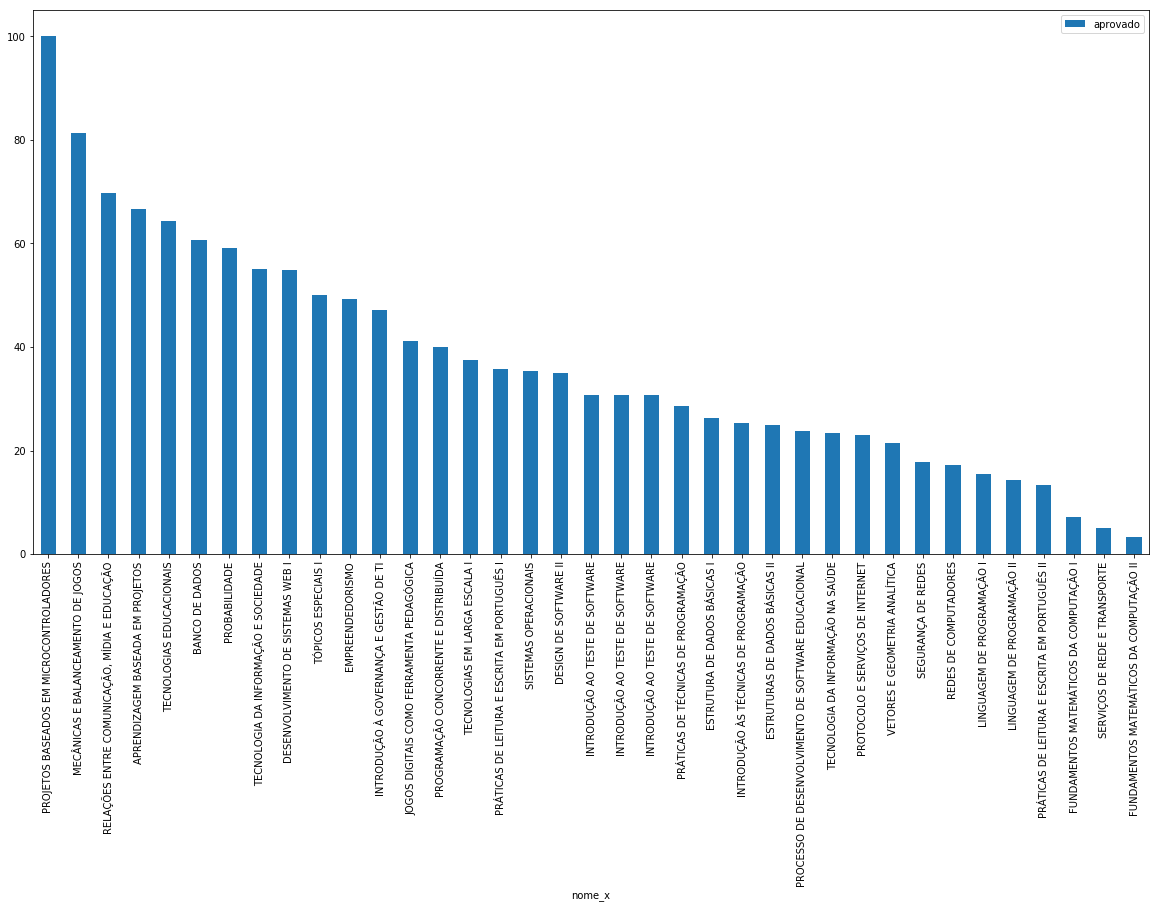

In [90]:
#Mostrando o resultado do tratamento do dataframe sobre as notas do IMD no semestre de 2017.2
plt.rcParams["figure.figsize"] = (20, 10)
aprovados_materias.plot(kind = 'bar')